# Period 1 -  Standard analyses for RNA seq data (unsupervised)


# Abstract

This workshop summarizes the main approaches to analyzing sequencing data to obtain per-gene count data, but does not go through how to do it explicitly. It demonstrates approaches to reading, annotating, and summarizing count data using [tximport](http://bioconductor.org/packages/) and various Bioconductor annotation resources, followed by unsupervised exploratory data analysis. It introduces the (Ranged)SummarizedExperiment data class,  variance-stabilizing transformations, and the use of distances to visualize transcriptome shifts through methods such as Principal Components Analysis and Multidimensional Scaling.

This workshop uses quotes and materials from [RNA-seq workflow: gene-level exploratory analysis and differential expression](https://www.bioconductor.org/help/workflows/rnaseqGene/) by Love, Anders, Kim, and Huber.

Next, we create a named vector pointing to the quantification
files. We will create a vector of filenames first by reading in a
table that contains the sample IDs, and then combining this with `dir`
and `"quant.sf"`.

# The SummarizedExperiment data class for representing RNA-seq data

**The component parts of a *SummarizedExperiment* object.** 

* `assay(se)` or `assays(se)$counts` contains the matrix of counts
* `colData(se)` may contain data about the columns, e.g. patients or biological units
* `rowData(se)` may contain data about the rows, e.g. genes or transcript
* `rowRanges(se)` may contain genomic ranges for the genes/transcripts
* `metadata(se)` may contain information about the experiment

<img src="https://github.com/waldronlab/BrownCOBRE2018/blob/master/notebooks_day2/SummarizedExperiment.jpg?raw=true" alt="summarized experiment figure" style="height: 350px;">

**Note**: The `rowRanges` could be a *GRanges* providing ranges of genes, or a *GRangesList* providing ranges of exons grouped by gene.  Both are accessible from TxDb databases.

*RangedSummarizedExperiment* is a subclass of *SummarizedExperiment*, where the *rowRanges* is not empty. You can convert a *SummarizedExperiment* to a *RangedSummarizedExperiment* just by setting its *rowRanges*. 

Some exploratory analysis of a demo *RangedSummarizedExperiment*:

In [2]:
suppressPackageStartupMessages({
    library(airway)
    library(SummarizedExperiment)
})

For the purposes of this tutorial, we will be using a default dataset that is part of R's 'airway' package.  The following command loads the 'airway' dataset into our R environment:

In [3]:
data(airway)

In [7]:
airway

class: RangedSummarizedExperiment 
dim: 64102 8 
metadata(1): ''
assays(1): counts
rownames(64102): ENSG00000000003 ENSG00000000005 ... LRG_98 LRG_99
rowData names(0):
colnames(8): SRR1039508 SRR1039509 ... SRR1039520 SRR1039521
colData names(9): SampleName cell ... Sample BioSample

## Characterizing the Dataset

Now, we will call some basic functions on this dataset to get a better sense of its fundamental characteristics, including dimensions, the number of counts present for each sample, and its structure:

In [8]:
dim(airway)

[1] 64102     8

In [9]:
assayNames(airway)

[1] "counts"

In [10]:
head(assay(airway), 3)

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508


In [11]:
colSums(assay(airway))

SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517 SRR1039520 
  20637971   18809481   25348649   15163415   24448408   30818215   19126151 
SRR1039521 
  21164133

The `rowRanges` here is a *GRangesList*. The first gene has 17 exons:

In [12]:
rowRanges(airway)

GRangesList object of length 64102:
$ENSG00000000003 
GRanges object with 17 ranges and 2 metadata columns:
       seqnames            ranges strand |   exon_id       exon_name
          <Rle>         <IRanges>  <Rle> | <integer>     <character>
   [1]        X 99883667-99884983      - |    667145 ENSE00001459322
   [2]        X 99885756-99885863      - |    667146 ENSE00000868868
   [3]        X 99887482-99887565      - |    667147 ENSE00000401072
   [4]        X 99887538-99887565      - |    667148 ENSE00001849132
   [5]        X 99888402-99888536      - |    667149 ENSE00003554016
   ...      ...               ...    ... .       ...             ...
  [13]        X 99890555-99890743      - |    667156 ENSE00003512331
  [14]        X 99891188-99891686      - |    667158 ENSE00001886883
  [15]        X 99891605-99891803      - |    667159 ENSE00001855382
  [16]        X 99891790-99892101      - |    667160 ENSE00001863395
  [17]        X 99894942-99894988      - |    667161 ENSE0000182

The `rowRanges` object also contains information about the gene model in the `metadata` slot. Here we use a helpful R function, `str`, to display the metadata compactly:

In [13]:
str(metadata(rowRanges(airway)))

List of 1
 $ genomeInfo:List of 20
  ..$ Db type                                 : chr "TranscriptDb"
  ..$ Supporting package                      : chr "GenomicFeatures"
  ..$ Data source                             : chr "BioMart"
  ..$ Organism                                : chr "Homo sapiens"
  ..$ Resource URL                            : chr "www.biomart.org:80"
  ..$ BioMart database                        : chr "ensembl"
  ..$ BioMart database version                : chr "ENSEMBL GENES 75 (SANGER UK)"
  ..$ BioMart dataset                         : chr "hsapiens_gene_ensembl"
  ..$ BioMart dataset description             : chr "Homo sapiens genes (GRCh37.p13)"
  ..$ BioMart dataset version                 : chr "GRCh37.p13"
  ..$ Full dataset                            : chr "yes"
  ..$ miRBase build ID                        : chr NA
  ..$ transcript_nrow                         : chr "215647"
  ..$ exon_nrow                               : chr "745593"
  ..$ cds_nrow     

The `colData`:

In [14]:
colData(airway)

DataFrame with 8 rows and 9 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862   N61311    untrt    untrt SRR1039508       126
SRR1039509 GSM1275863   N61311      trt    untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611      trt    untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611      trt    untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011      trt    untrt SRR1039521        98
           Experiment    Sample    BioSample
             <factor>  <factor>     <factor>
SRR1039508  SRX384345 SRS508568 SAMN02422669
SRR1039509  SRX384346 SRS508567 SAMN02422675
SRR1039512  SRX384349 SRS508571 SAMN02422678
SRR1039513  SRX384350 SRS508572 SAMN024


#  Exploratory data analysis

## Standardization / transformation of count data for visual exploration

Features (e.g. genes) are typically "standardized", because: 
1.  the differences in overall levels between features are often not due to biological effects but technical ones, *e.g.* GC bias, PCR amplification efficiency, ...
2. otherwise a few very high-variance genes can dominate the distance, and make the distances less biologically relevant

Standardization traditionally meant converting to z-score:

$$x_{gi} \leftarrow \frac{(x_{gi} - \bar{x}_g)}{s_g}$$     

But `DESeq2` and `edgeR` provide their own RNA-seq specific standardization methods.

We will use standardization for the purposes of visualization below, but for statistical testing in the next period, we will go back to the original count data 
as required by the statistical procedures used.

## Exploring the airway dataset

Once we have our fully annotated *SummarizedExperiment* object,
we can construct a *DESeqDataSet* object from it that will then form
the starting point of the analysis.
We add an appropriate design for the analysis:

In [4]:
suppressPackageStartupMessages(library(DESeq2))

In [5]:
dds <- DESeqDataSet(airway, design = ~ cell + dex)

Of particular note is the model formula, which is passed as the `design` argument.  Here, `~ cell + dex` means that we are concerned with two covariates, `cell` and `dex`.  `~` is how R denotes a model.

# Model specification

[Model formulae tutorial](http://ww2.coastal.edu/kingw/statistics/R-tutorials/formulae.html)

* Many regression functions in R use a standard "model formula" syntax
* DEseq is a special case of regression that utilizes a negative binomial distribution
* The formula determines the model that will be built (and tested) by the R procedure. The basic format is:

`> outcome (or response) variable ~ explanatory variables (or predictors)`

* The tilde means "is modeled by" or "is modeled as a function of" - **here, the left side of the model is implicit because DEseq is acting on a matrix of counts; these counts constitute the outcome/response**, so no explicit specification of the response is required

## Essential model formula syntax

symbol  | example | meaning
------- | ------------ | --------------------------  
+ | + x	| include this variable  
-	| - x	| delete this variable  
:	| x : z	| include the interaction  
*	| x * z	| include these variables and their interactions  
^	| (u + v + w)^3	| include these variables and all interactions up to three way\*
1 | -1 | intercept: delete the intercept  

\* i.e. u + v + w + uv + uw + vw + uvw

Note: order generally doesn't matter (u+v OR v+u evaluate to the same mathematical model)

*Examples*: `~treatment`, `~treatment + time`, `~treatment * time`


# The Design Matrix

## The Design Matrix

Use an example of a multiple linear regression model:

$y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi} + \epsilon_i$

- $x_{ji}$ is the value of predictor $x_j$ for observation $i$

## The Design Matrix

Matrix notation for the multiple linear regression model:

$$
\,
\begin{pmatrix}
Y_1\\
Y_2\\
\vdots\\
Y_N
\end{pmatrix} = 
\begin{pmatrix}
1&x_1\\
1&x_2\\
\vdots\\
1&x_N
\end{pmatrix}
\begin{pmatrix}
\beta_0\\
\beta_1
\end{pmatrix} +
\begin{pmatrix}
\varepsilon_1\\
\varepsilon_2\\
\vdots\\
\varepsilon_N
\end{pmatrix}
$$

or simply: 

$$
\mathbf{Y}=\mathbf{X}\boldsymbol{\beta}+\boldsymbol{\varepsilon}
$$

* The design matrix is $\mathbf{X}$
    * which the computer will take as a given when solving for $\boldsymbol{\beta}$ by minimizing the sum of squares of residuals $\boldsymbol{\varepsilon}$.
    

There are multiple possible and reasonable design matrices for a given study design
* the model formula encodes a default model matrix, e.g.:

In [ ]:
group <- factor( c(1, 1, 2, 2) )
model.matrix(~ group)

What if we forgot to code group as a factor, and instead left it as numeric?

In [ ]:
group <- c(1, 1, 2, 2)
model.matrix(~ group)

Here is an example again of a single predictor, but with more groups

In [ ]:
group <- factor(c(1,1,2,2,3,3))
model.matrix(~ group)

The _baseline_ or _reference_ group is the one that other groups are contrasted against. You can change the baseline group:

In [ ]:
group <- factor(c(1,1,2,2,3,3))
group <- relevel(x=group, ref=3)
model.matrix(~ group)

The model matrix can represent multiple predictors, ie multiple (linear/log-linear/logistic) regression:

In [ ]:
diet <- factor(c(1,1,1,1,2,2,2,2))
sex <- factor(c("f","f","m","m","f","f","m","m"))
model.matrix(~ diet + sex)

Why is `f` used as the default reference group instead of `m`?  Because ASCII ordering (alphanumeric) is default.

And manually adding interaction terms:

In [ ]:
model.matrix(~ diet + sex + diet:sex)

The result is the same as using the \* operator:

In [ ]:
model.matrix(~ diet * sex)

## Filtering genes not satisfying a minimum expression threshold

Our count matrix contains many rows with only
zeros, and additionally many rows with only a few fragments total. In
order to reduce the size of the object, and to increase the speed of
our functions, we can remove the rows that have no or nearly no
information about the amount of gene expression (rows very close to zero but not exactly zero are likely artefacts / noise not indicative of actual gene expression).  Here we apply the
most minimal and conservative filtering rule: removing rows of the *DESeqDataSet* that
have no counts, or only a single count across **all** samples. Additional
weighting/filtering to improve power is applied at a later step in the
workflow.

In [17]:
nrow(dds)

[1] 64102

In [6]:
dds <- dds[ rowSums(counts(dds)) > 1, ]
nrow(dds)

[1] 29391

NB: only 46% of the genes remain after performing this filtering step, demonstrating the degree to which our performance will be improved by discarding the noninformative entries.  A more stringent method of filtering, such as removing all genes that have any 0 count entries at all, would yield an even smaller percentage of genes.

**Note**: For differential expression analysis later, filtering is 
allowable but not necessary if using [Independent Hypothesis Weighting](http://www.bioconductor.org/packages/IHW),
as is the default behavior of `DESeq2`. Independent hypothesis weighting (IHW) is a multiple testing procedure that increases power compared to the method of Benjamini and Hochberg by assigning data-driven weights to each hypothesis. 

## The rlog and variance stabilizing transformations

Many common statistical methods for exploratory analysis of
multidimensional data, for example clustering and *principal
components analysis* (PCA), work best for data that generally has the
same range of variance at different ranges of the mean values. When
the expected amount of variance is approximately the same across
different mean values, the data is said to be *homoskedastic*. For
RNA-seq counts, however, the expected variance grows with the mean. For
example, **if one performs PCA directly on a matrix of
counts or normalized counts (e.g. correcting for differences in
sequencing depth), the resulting plot typically depends mostly
on the genes with *highest* counts because they show the largest
absolute differences between samples**. A simple and often used
strategy to avoid this is to take the logarithm of the normalized
count values plus a pseudocount of 1 (to account for 0-count observations, as the log of 0 is undefined and the log of 1 is always 0 irrespective of base); however, depending on the
choice of pseudocount, the genes with the very *lowest* counts
will contribute a great deal of noise to the resulting plot, because
taking the logarithm of small counts actually inflates their variance.
We can quickly show this property of counts with simulated
data (here, Poisson-distributed counts with a range of lambda from 0.1 to 100).
We plot the standard deviation of each row (genes) against the mean:

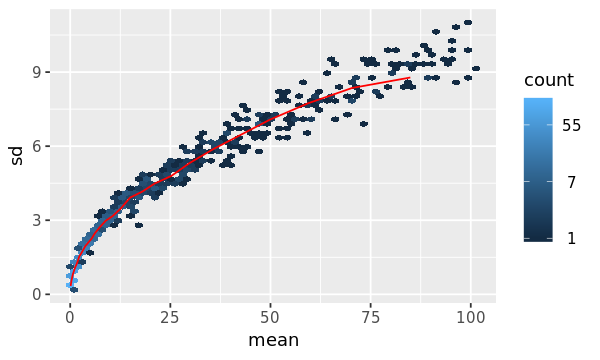

In [19]:
options(repr.plot.height=3, repr.plot.width=5)
lambda <- 10^seq(from = -1, to = 2, length = 1000)
cts <- matrix(rpois(1000*100, lambda), ncol = 100)
library(vsn)
meanSdPlot(cts, ranks = FALSE)

And for logarithm-transformed counts:

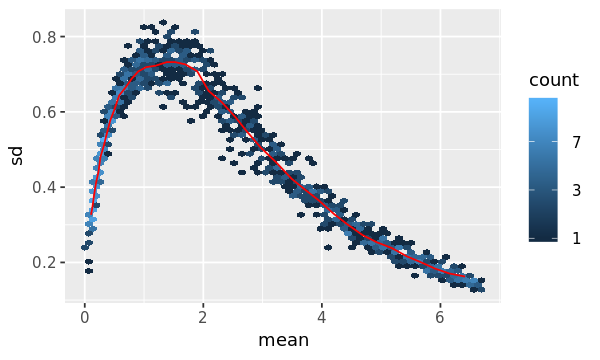

In [20]:
options(repr.plot.height=3, repr.plot.width=5)
log.cts.one <- log2(cts + 1)
meanSdPlot(log.cts.one, ranks = FALSE)

The logarithm with a small pseudocount amplifies differences when the
values are close to 0. The low count genes with low signal-to-noise
ratio will overly contribute to sample-sample distances and PCA
plots. 

As a solution, *DESeq2* offers two transformations for count data that
stabilize the variance across the mean: the 
*regularized-logarithm transformation* or *rlog* ([Love, Huber, Anders, Genome Biology 2014](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8)),
and the *variance stabilizing transformation* (VST)
for negative binomial data with a dispersion-mean trend
([Anders and Huber, Genome Biology 2010](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-10-r106)), implemented in the *vst* function.

For genes with high counts, the rlog and VST will give similar result
to the ordinary log2 transformation of normalized counts.  **For genes
with lower counts, however, the values are shrunken towards the genes'
averages across all samples**. The rlog-transformed or VST data then
becomes approximately homoskedastic, and can be used directly for
computing distances between samples, making PCA plots, or as input to
downstream methods which perform best with homoskedastic data.

**Which transformation to choose?** The rlog tends to work well on
small datasets (n < 30), sometimes outperforming the VST when there is
a large range of sequencing depth across samples (an order of
magnitude difference). The VST is much faster to compute and is less
sensitive to high count outliers than the rlog. We therefore recommend
the VST for large datasets (hundreds of samples). You can perform both
transformations and compare the `meanSdPlot` or PCA plots generated,
as described below.

Note that the two transformations offered by DESeq2 are provided for
applications *other* than differential testing. 
For differential testing we recommend the
*DESeq* function applied to raw counts, as described later
in this workflow, which also takes into account the dependence of the
variance of counts on the mean value during the dispersion estimation
step.

The function `rlog` returns an object based on the *SummarizedExperiment*
class that contains the rlog-transformed values in its *assay* slot.  The *assay* slot is merely the piece of the `dds` object that contains the actual counts (as opposed to other information like metadata).  R is programmed to know that when you call `rlog` on a dds object, it should transform the contents of the *assay* slot and not the entire object.

First, we will depict the untransformed data, against which we can visually compare the results of the two aforementioned transformations.  Note the extreme outliers and leverage points in the upper right of the plot, each colored dark blue to show that only one gene falls within each point - these observations would cause a great deal of bias in the result if uncorrected:

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229


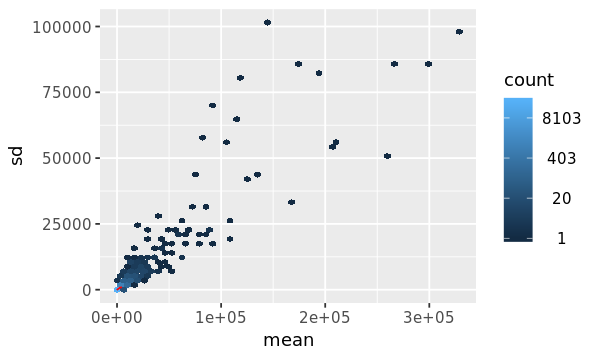

In [8]:
suppressPackageStartupMessages(library(vsn))
options(repr.plot.height=3, repr.plot.width=5)
head(assay(dds), 3)
meanSdPlot(assay(dds), ranks=FALSE)

Now we will implement the `rlog` function:

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.385681,9.052599,9.516877,9.285335,9.839093,9.530313,9.663260,9.277695
ENSG00000000419,8.869611,9.138274,9.036117,9.075296,8.972125,9.131828,8.861529,9.060906
ENSG00000000457,7.961373,7.881385,7.824075,7.921493,7.751690,7.886441,7.957126,7.912125


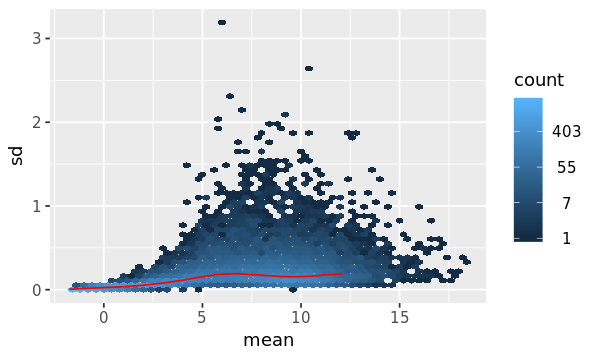

In [21]:
options(repr.plot.height=3, repr.plot.width=5)
rld <- rlog(dds, blind = FALSE)
head(assay(rld), 3)
meanSdPlot(assay(rld), ranks=FALSE)

The function `vst` returns a similar object:

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.742074,9.430420,9.867626,9.645844,10.183143,9.880416,10.010366,9.639782
ENSG00000000419,9.333668,9.581706,9.486145,9.523093,9.427283,9.574860,9.325998,9.509246
ENSG00000000457,8.765274,8.698448,8.651473,8.732426,8.592786,8.702673,8.761945,8.724101


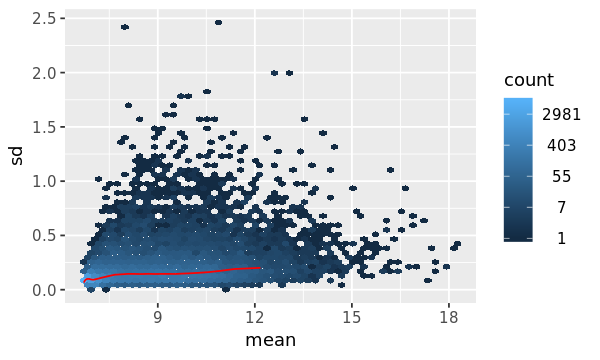

In [22]:
vsd <- vst(dds, blind = FALSE)
head(assay(vsd), 3)
meanSdPlot(assay(vsd), ranks=FALSE)

In the above function calls, we specified `blind = FALSE`, which means
that differences between cell lines and treatment (the variables in
the design) will not contribute to the expected variance-mean trend of
the experiment. The experimental design is not used directly in the
transformation, only in estimating the global amount of variability in
the counts.  For a fully *unsupervised* transformation, one can set
`blind = TRUE` (which is the default).

To show the effect of the transformation, in the figure below
we plot the first sample
against the second, first simply using the *log2* function (after adding
1, to avoid taking the log of zero, which as previously mentioned is undefined and would cause an error), and then using the rlog- and VST-transformed
values. **For the *log2* approach, we need to first estimate *size factors* to
account for sequencing depth**, and then specify `normalized=TRUE`.
Sequencing depth correction is done automatically for the *rlog*
and the *vst*.

In [23]:
dds <- estimateSizeFactors(dds)

In [24]:
ddsESF <- estimateSizeFactors(dds)
df1 <- data.frame(log2(counts(ddsESF, normalized=TRUE)[, 1:2] + 1))
df1$transformation <- "log2(x + 1)"
df2 <- data.frame(assay(rld)[, 1:2])
df2$transformation <- "rld"
df3 <- data.frame(assay(vsd)[, 1:2])
df3$transformation <- "vsd"
df <- rbind(df1, df2, df3)
colnames(df)[1:2] <- c("x", "y")
head(df)
table(df$transformation)

,x,y,transformation
ENSG00000000003,9.375722,8.968399,log2(x + 1)
ENSG00000000419,8.836718,9.169098,log2(x + 1)
ENSG00000000457,7.994317,7.885375,log2(x + 1)
ENSG00000000460,5.897577,5.962838,log2(x + 1)
ENSG00000000938,0.000000,0.000000,log2(x + 1)
ENSG00000000971,11.633403,12.003610,log2(x + 1)


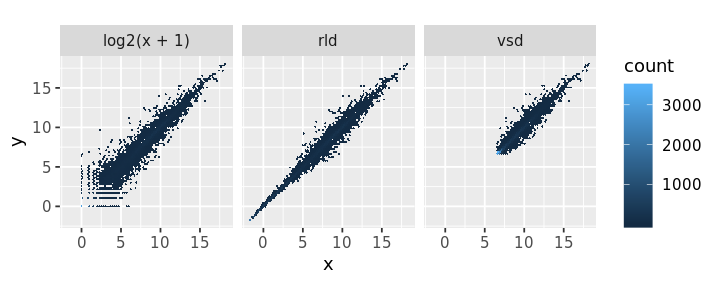

In [25]:
options(repr.plot.width=6, repr.plot.height=2.5)
library(ggplot2)
ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

**Scatterplot of transformed counts from two samples**. Shown are
scatterplots using the log2 transform of normalized counts (left),
using the rlog (middle), and using the VST (right). While the rlog is
on roughly the same scale as the log2 counts, the VST has a upward
shift for the smaller values. It is the differences between samples
(deviation from y=x in these scatterplots) which will contribute to
the distance calculations and the PCA plot.

We can see how genes with low counts (bottom left-hand corner) seem to
be excessively variable on the ordinary logarithmic scale, while the
rlog transform and VST compress differences for the low count genes
for which the data provide little information about differential
expression.  As any differences in these low-count values are likely artefacts introduced by error or random chance, their exclusion helps to prevent false positives.

## Boxplots of transformed distributions

Boxplots of the count distributions in each sample are a good way to understand the effects these transformations have at the level of individual subjects.

In R's boxplots, points classified as outliers are shown on the plots as circles.  Here, neither the log2 nor the rld transformations include any outliers, while the vsd transformations do have outliers at the upper end of the distributions.  These points are classified as outliers because the vsd method compresses lower end points more substantially, as can be seen on the scatter plot above - the actual magnitude of these points does not significantly exceed the magnitude seen with the other transformations.

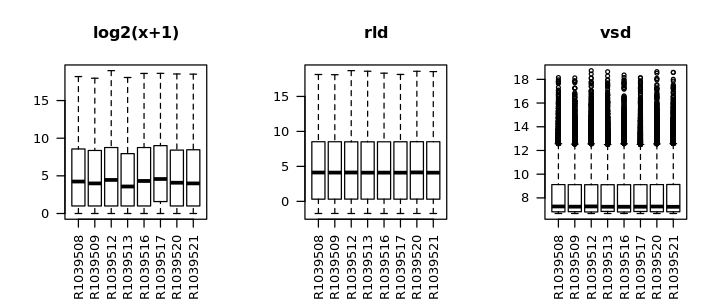

In [26]:
par(mfrow=c(1,3))
boxplot(log2(assay(ddsESF)+1), las=2, main="log2(x+1)")
boxplot(assay(rld), las=2, main="rld")
boxplot(assay(vsd), las=2, main="vsd")

# Sample distances

## The importance of distances

High-dimensional data are complex and impossible to visualize in raw form. They represent
thousands of dimensions, but we can only visualize 2-3.

All clustering and classification of samples and/or genes involves
combining or identifying objects that are close or similar. Distances 
or similarities are mathematical representations of what we mean by 
close or similar. The choice of distance is important and varies for different subject areas and types of data.

See: http://master.bioconductor.org/help/course-materials/2002/Summer02Course/Distance/distance.pdf

## Distances for exploratory RNA-seq data analysis

A useful first step in an RNA-seq analysis is often to assess overall
similarity between samples: Which samples are similar to each other,
which are different? Does this fit to the expectation from the
experiment's design?

We use the R function *dist* to calculate the "Euclidean distance"
between samples; the Euclidean distance is simply the higher-dimensional analogue of the human-measurable distance between points in 2 or 3 dimensions.  To ensure we have a roughly equal contribution from
all genes, we calculate it from the rlog-transformed data. We need to
transpose the matrix of values using `t`, because the `dist` function
expects the different samples to be **rows** of its argument, and
different dimensions (here, genes) to be **columns**.

In [27]:
sampleDists <- dist(t(assay(rld)))
sampleDists

           SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517
SRR1039509   45.70157                                                       
SRR1039512   39.25600   54.91229                                            
SRR1039513   62.63599   44.53085   48.72888                                 
SRR1039516   44.50962   59.06803   43.58242   63.74707                      
SRR1039517   64.49868   51.45303   59.23397   49.88394   47.48509           
SRR1039520   39.58027   57.46654   36.74746   58.49397   46.41179   63.60395
SRR1039521   63.36521   45.06068   57.87997   36.49799   65.55042   52.32104
           SRR1039520
SRR1039509           
SRR1039512           
SRR1039513           
SRR1039516           
SRR1039517           
SRR1039520           
SRR1039521   50.13745

We visualize the distances in a heatmap in a figure below, using the function
`pheatmap` from the [pheatmap](https://cran.r-project.org/web/packages/pheatmap/index.html) package.

In [28]:
library(pheatmap)
library(RColorBrewer)

In order to plot the sample distance matrix with the rows/columns
arranged by the distances in our distance matrix,
we manually provide `sampleDists` to the `clustering_distance`
argument of the `pheatmap` function.
Otherwise the `pheatmap` function would assume that the matrix contains
the data values themselves, and would calculate distances between the
rows/columns of the distance matrix, which is not desired.
We also manually specify a blue color palette using the
`colorRampPalette` function from the [RColorBrewer](https://cran.r-project.org/web/packages/RColorBrewer/index.html) package (this coloring step is optional and is determined by user preference).

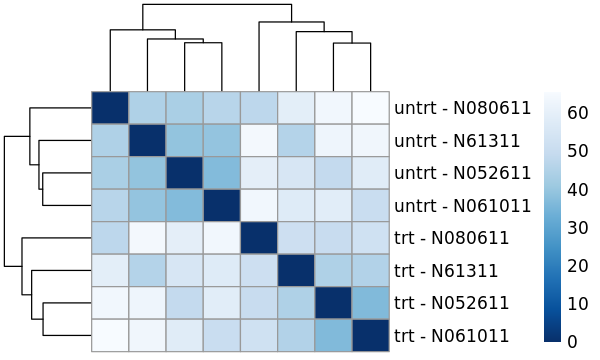

In [29]:
options(repr.plot.height=3, repr.plot.width=5)
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$dex, rld$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

**Heatmap of sample-to-sample distances using the rlog-transformed values.**

Note that we have changed the row names of the distance matrix to
contain treatment type and patient number instead of sample ID, so
that we have all this information in view when looking at the heatmap.

Another option for calculating sample distances is to use the
Poisson Distance, implemented in the
[PoiClaClu](https://cran.r-project.org/web/packages/PoiClaClu/index.html) CRAN package.
This measure of dissimilarity between counts
also takes the inherent variance
structure of counts into consideration when calculating the distances
between samples. The `PoissonDistance` function takes the original
count matrix (not normalized) with samples as rows instead of columns,
so we need to transpose the counts in `dds`.

In [30]:
library(PoiClaClu)
poisd <- PoissonDistance(t(counts(ddsESF)))

We plot the heatmap below.

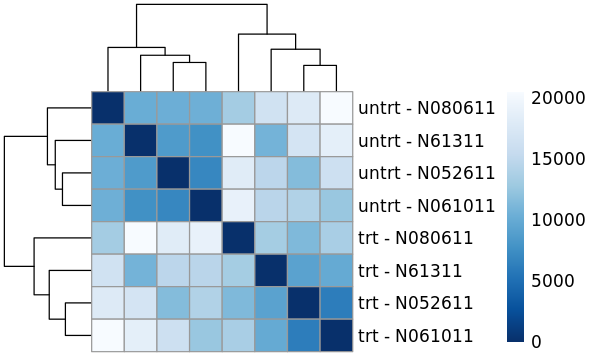

In [31]:
options(repr.plot.height=3, repr.plot.width=5)
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)

**Heatmap of sample-to-sample distances using the *Poisson Distance*.**

## PCA plot

Another way to visualize sample-to-sample distances is a
principal components analysis (PCA). In this ordination method, the
data points (here, the samples) are projected onto the 2D plane
such that they spread out in the two directions that explain most of
the differences (figure below). The x-axis is the direction that separates the data
points the most. The values of the samples in this direction are
written *PC1* ("principal component 1"). The y-axis is a direction (it must be *orthogonal* - perpendicular - to
the first direction) that separates the data the second most. The
values of the samples in this direction are written *PC2*.
The percent of the total variance that is contained in the direction
is printed in the axis label. Note that these percentages do not add to
100%, because there are more dimensions - often many of them - that contain the remaining
variance (although each of these remaining dimensions will by definition explain
less than the two that we see).

DataFrame with 8 rows and 10 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862   N61311    untrt    untrt SRR1039508       126
SRR1039509 GSM1275863   N61311      trt    untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611      trt    untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611      trt    untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011      trt    untrt SRR1039521        98
           Experiment    Sample    BioSample        sizeFactor
             <factor>  <factor>     <factor>         <numeric>
SRR1039508  SRX384345 SRS508568 SAMN02422669  1.02364764926706
SRR1039509  SRX384346 SRS508567 SAMN02422675 0.896166721793923
SRR1039512 

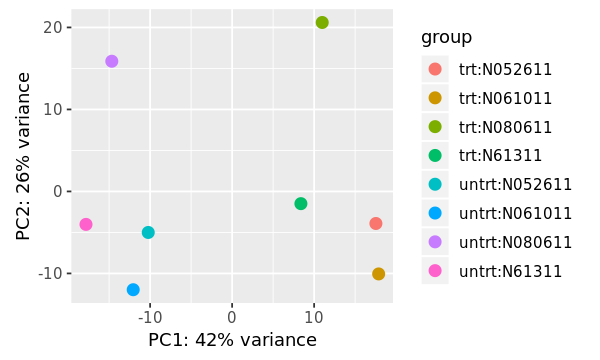

In [48]:
colData(rld)
plotPCA(rld, intgroup = c("dex", "cell"))

**PCA plot using the rlog-transformed values.** Each unique combination of
treatment and cell line is given its own color.

Here, we have used the function `plotPCA()` that comes with *DESeq2*.
The two terms specified by `intgroup` are the interesting groups for
labeling the samples; they tell the function to use them to choose
colors. We can also build the PCA plot from scratch using the
[ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html) package.
This is done by asking the `plotPCA()` function
to return the data used for plotting rather than building the plot.
See the *ggplot2* [documentation](http://docs.ggplot2.org/current/)
for more details on using `ggplot()`.

In [33]:
pcaData <- plotPCA(rld, intgroup = c( "dex", "cell"), returnData = TRUE)
pcaData
percentVar <- round(100 * attr(pcaData, "percentVar"))

,PC1,PC2,group,dex,cell,name
SRR1039508,-17.818478,-4.021260,untrt:N61311,untrt,N61311,SRR1039508
SRR1039509,8.388115,-1.491329,trt:N61311,trt,N61311,SRR1039509
SRR1039512,-10.227671,-5.004222,untrt:N052611,untrt,N052611,SRR1039512
SRR1039513,17.533464,-3.910088,trt:N052611,trt,N052611,SRR1039513
SRR1039516,-14.672156,15.874223,untrt:N080611,untrt,N080611,SRR1039516
SRR1039517,10.988342,20.599713,trt:N080611,trt,N080611,SRR1039517
SRR1039520,-12.060845,-11.986221,untrt:N061011,untrt,N061011,SRR1039520
SRR1039521,17.869229,-10.060816,trt:N061011,trt,N061011,SRR1039521


We can then use this structure to build up a second plot in a figure below, specifying that the
color of the points should reflect dexamethasone treatment and the
shape should reflect the cell line.

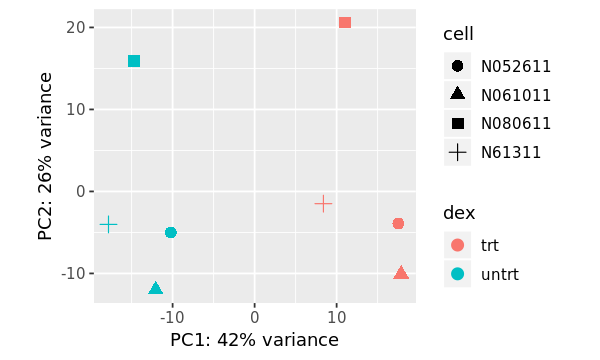

In [34]:
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()

**PCA plot using the rlog-transformed values with custom *ggplot2* code.**
Here we specify cell line (plotting symbol) and dexamethasone treatment (color).

From the PCA plot, we see that the differences between cells (the
different plotting shapes) are considerable, though not stronger than the differences due to
treatment with dexamethasone (red vs blue color). This shows why it will be important to
account for this in differential testing by using a paired design
("paired", because each dex treated sample is paired with one
untreated sample from the *same* cell line). We are already set up for
this design by assigning the formula `~ cell + dex` earlier when specifying our model.

## MDS plot

Another plot, very similar to the PCA plot, can be made using the 
*multidimensional scaling* (MDS) function in base R. This is useful when we
don't have a matrix of data, but only a matrix of distances. Here we
compute the MDS for the distances calculated from the *rlog*
transformed counts and plot these in a figure below.

This method, unlike PCA, does not show the percent of variance explained by the individual components.

**MDS plot using rlog-transformed values.**

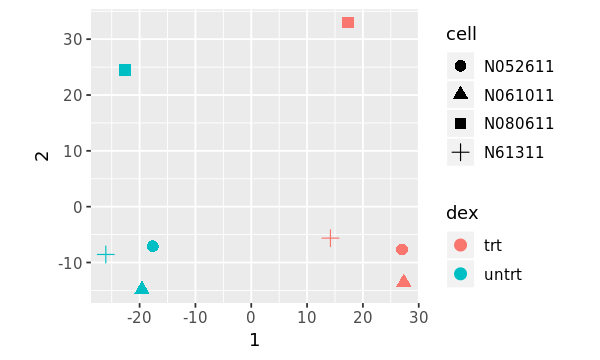

In [35]:
mds <- cbind(as.data.frame(colData(rld)), cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

In the figure below we show the same plot for the *PoissonDistance*.  Note the difference in axis scale.

**MDS plot using the *Poisson Distance*.**

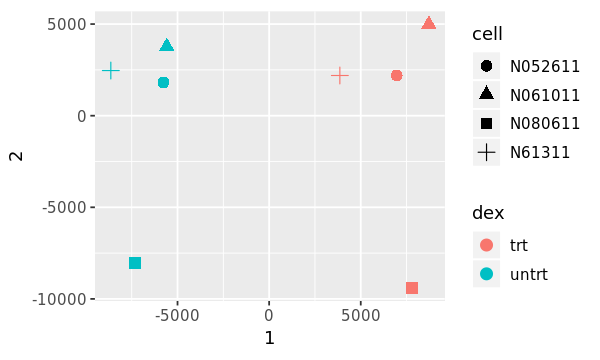

In [36]:
mdsPois <- cbind(as.data.frame(colData(ddsESF)),
   cmdscale(samplePoisDistMatrix))
ggplot(mdsPois, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

**Exercise**: The following code will read example `.bam` files containing only reads from human chromosome 14, and count overlaps with known genes on chromosome 14. Follow these steps, then perform exploratory analysis on the resulting data object:

library(RNAseqData.HNRNPC.bam.chr14)
bfp = RNAseqData.HNRNPC.bam.chr14_BAMFILES
library(Rsamtools)
bfl = BamFileList(file=bfp)
library(Homo.sapiens)
gr14 = genes(Homo.sapiens, filter=list(tx_chrom="chr14"), columns="SYMBOL")
library(GenomicAlignments)
rse <- summarizeOverlaps(gr14, bfl)

# Appendix <a name="appendix"></a>

## Additional options for mapping transcripts to genes

**Option 2.** Bioconductor `TxDb.*` packages, which are available for a number of model species (search for "TxDb" at https://bioconductor.org/packages/3.6/data/annotation/). These are slightly less convenient for this purpose than the Ensembl packages. For example, there is a TxDb package Mus Musculus from UCSC build mm10 based on the knownGene Track:

In [37]:
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
keytypes(txdb)
k <- keys(txdb, "TXNAME")
columns(txdb)
tx4gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")

Loading required package: GenomicFeatures
Loading required package: AnnotationDbi


[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSSTART"  
 [6] "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"     "EXONNAME"  
[11] "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"     "TXCHROM"   
[16] "TXEND"      "TXID"       "TXNAME"     "TXSTART"    "TXSTRAND"  
[21] "TXTYPE"

'select()' returned 1:1 mapping between keys and columns


In [38]:
genes(txdb)
exonsBy(txdb)

GRanges object with 24044 ranges and 1 metadata column:
            seqnames              ranges strand |     gene_id
               <Rle>           <IRanges>  <Rle> | <character>
  100009600     chr9   21062393-21075496      - |   100009600
  100009609     chr7   84940169-84964009      - |   100009609
  100009614    chr10   77711446-77712009      + |   100009614
  100009664    chr11   45808083-45842878      + |   100009664
     100012     chr4 144157556-144162651      - |      100012
        ...      ...                 ...    ... .         ...
      99889     chr3   84496093-85887518      - |       99889
      99890     chr3 110246104-110250999      - |       99890
      99899     chr3 151730923-151749959      - |       99899
      99929     chr3   65528447-65555518      + |       99929
      99982     chr4 136550533-136602723      - |       99982
  -------
  seqinfo: 66 sequences (1 circular) from mm10 genome

GRangesList object of length 63759:
$1 
GRanges object with 8 ranges and 3 metadata columns:
      seqnames          ranges strand |   exon_id   exon_name exon_rank
         <Rle>       <IRanges>  <Rle> | <integer> <character> <integer>
  [1]     chr1 4807893-4807982      + |         1        <NA>         1
  [2]     chr1 4808455-4808486      + |         2        <NA>         2
  [3]     chr1 4828584-4828649      + |         3        <NA>         3
  [4]     chr1 4830268-4830315      + |         4        <NA>         4
  [5]     chr1 4832311-4832381      + |         5        <NA>         5
  [6]     chr1 4837001-4837074      + |         6        <NA>         6
  [7]     chr1 4839387-4839488      + |         7        <NA>         7
  [8]     chr1 4840956-4842827      + |         9        <NA>         8

$2 
GRanges object with 9 ranges and 3 metadata columns:
      seqnames          ranges strand | exon_id exon_name exon_rank
  [1]     chr1 4807893-4807982      + |       1      <NA>    

**Option 3.** Find a TxDb from AnnotationHub

This opens up more annotation files from different sources. First find and choose a TxDb database:

In [39]:
suppressPackageStartupMessages(library(AnnotationHub))
ah <- AnnotationHub()
query(ah, "TxDb")
txdb <- ah[["AH52245"]] #TxDb.Athaliana.BioMart.plantsmart22.sqlite

updating metadata: retrieving 1 resource
snapshotDate(): 2018-04-30


AnnotationHub with 59 records
# snapshotDate(): 2018-04-30 
# $dataprovider: UCSC
# $species: Rattus norvegicus, Gallus gallus, Macaca mulatta, Caenorhabditis...
# $rdataclass: TxDb
# additional mcols(): taxonomyid, genome, description,
#   coordinate_1_based, maintainer, rdatadateadded, preparerclass, tags,
#   rdatapath, sourceurl, sourcetype 
# retrieve records with, e.g., 'object[["AH52245"]]' 

            title                                        
  AH52245 | TxDb.Athaliana.BioMart.plantsmart22.sqlite   
  AH52246 | TxDb.Athaliana.BioMart.plantsmart25.sqlite   
  AH52247 | TxDb.Athaliana.BioMart.plantsmart28.sqlite   
  AH52248 | TxDb.Btaurus.UCSC.bosTau8.refGene.sqlite     
  AH52249 | TxDb.Celegans.UCSC.ce11.refGene.sqlite       
  ...       ...                                          
  AH61796 | TxDb.Mmulatta.UCSC.rheMac8.refGene.sqlite    
  AH61797 | TxDb.Ptroglodytes.UCSC.panTro4.refGene.sqlite
  AH61798 | TxDb.Rnorvegicus.UCSC.rn5.refGene.sqlite     
  AH61799 | TxDb.

downloading 1 resources
retrieving 1 resource
loading from cache 
    ‘/home/ubuntu//.AnnotationHub/58983’


Then use it to create the transcript-gene map:

In [40]:
keytypes(txdb)

[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

In [41]:
columns(txdb)

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSSTART"  
 [6] "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"     "EXONNAME"  
[11] "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"     "TXCHROM"   
[16] "TXEND"      "TXID"       "TXNAME"     "TXSTART"    "TXSTRAND"

In [42]:
k <- keys(txdb, "TXNAME")
tx5gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")
head(tx5gene)

'select()' returned 1:1 mapping between keys and columns


TXNAME,GENEID
AT1G01010.1,AT1G01010
AT1G01040.1,AT1G01040
AT1G01040.2,AT1G01040
AT1G01046.1,AT1G01046
AT1G01073.1,AT1G01073
AT1G01110.2,AT1G01110


** Option 4.** Import a GFF annotation file from somewhere else.

To convert the GFF file these to a TxDb database, use the `makeTxDbFromGFF()` function from the `GenomicFeatures` package:

In [43]:
library(GenomicFeatures)
gffFile <- system.file("extdata", "GFF3_files", "a.gff3", 
                       package="GenomicFeatures")
txdb <- makeTxDbFromGFF(file=gffFile,
            dataSource="partial gtf file for Tomatoes for testing",
            organism="Solanum lycopersicum")
keytypes(txdb)

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(type, phase):
“The "phase" metadata column contains non-NA values for features of type
  exon. This information was ignored.”OK


[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

In [44]:
columns(txdb)

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSPHASE"  
 [6] "CDSSTART"   "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"    
[11] "EXONNAME"   "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"    
[16] "TXCHROM"    "TXEND"      "TXID"       "TXNAME"     "TXSTART"   
[21] "TXSTRAND"   "TXTYPE"

In [45]:
k <- keys(txdb, "TXNAME")
tx6gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")
head(tx5gene)

'select()' returned 1:1 mapping between keys and columns


TXNAME,GENEID
AT1G01010.1,AT1G01010
AT1G01040.1,AT1G01040
AT1G01040.2,AT1G01040
AT1G01046.1,AT1G01046
AT1G01073.1,AT1G01073
AT1G01110.2,AT1G01110


Note, the `GenomicFeatures` package enables you to make a TxDb from a variety of sources:

In [46]:
grep("makeTxDb", ls("package:GenomicFeatures"), val=TRUE)

[1] "makeTxDb"                   "makeTxDbFromBiomart"       
[3] "makeTxDbFromEnsembl"        "makeTxDbFromGFF"           
[5] "makeTxDbFromGRanges"        "makeTxDbFromUCSC"          
[7] "makeTxDbPackage"            "makeTxDbPackageFromBiomart"
[9] "makeTxDbPackageFromUCSC"